In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(0, '../LaurieOnTracking')


# https://github.com/Friends-of-Tracking-Data-FoTD/LaurieOnTracking/tree/master
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

# default libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline

import pandas as pd
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from scipy.stats import multivariate_normal

import numpy as np
from numpy import linalg as LA
from sklearn.preprocessing import MinMaxScaler

import functools
import operator


In [3]:
# load event data from Metrica always to use reverse function
DATADIR = '../sample-data-master/data'
game_id = 1 # let's look at sample match 2
match = 'metrica_1'

# read in the event data
events = mio.read_event_data(DATADIR,game_id)
if (match == 'metrica_1') or (match == 'metrica_2'):
    if match == 'metrica_1':
        game_id = 1 # let's look at sample match 1
    elif match == 'metrica_2':
        game_id = 2

    # read in the event data
    events = mio.read_event_data(DATADIR,game_id)

    # Bit of housekeeping: unit conversion from metric data units to meters
    events = mio.to_metric_coordinates(events)
    events.head()
    #### TRACKING DATA ####

    # READING IN TRACKING DATA
    tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
    tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

    # Convert positions from metrica units to meters 
    tracking_home = mio.to_metric_coordinates(tracking_home)
    tracking_away = mio.to_metric_coordinates(tracking_away)
    # reverse direction of play in the second half so that home team is always attacking from right->left
    tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)
    if match=='metrica_1':
        tracking_home, tracking_away, events= mio.change_playing_direction_both(tracking_home, tracking_away, events)
    #query features
    query_features = pd.read_csv('.././results' + '/metrica_' + str(game_id) +
                                     '_query_features.csv', sep=";")
    


Reading team: home
Reading team: away


In [4]:
# standardize data to get zero mean
from sklearn.preprocessing import StandardScaler

# Make a copy
tracking_home_xy = pd.DataFrame()

# create new colums with in [x,y] formation

# Function to flatten nested list to list
def functools_reduce_iconcat(a):
    return functools.reduce(operator.iconcat, a, [])


def gen_coordinates_xy(team, side='Home'):
    """ Create Dataframe with player coordinates in [x,y] format
    
    Args:
        team: row (i.e. instant) of the home team tracking data frame
        side: boolean ('Home' or 'Away') indicting the origin of the the team dataframe
    
    Returns:
           team_xy: Dataframe with 14 columns with coordinates of the player in [x,y] format
    """
    team_xy = pd.DataFrame()
    for i in range(1, 15):
        coos = []
        coos.extend([list(a) for a in 
            zip(team[side + '_' + str(i) + '_x'], team[side + '_' + str(i) + '_y'])])
        team_xy[side + '_' + str(i) +'_xy'] = coos
    return team_xy    

tracking_home_xy = gen_coordinates_xy(tracking_home, 'Home')

# select new columns
#tracking_home_std = tracking_home_xy.iloc[:,32:46]

def standardize_coordinates_frame(team_xy, frame):
    """ standardizes the Dataframe with player coordinates in [x,y] format to have zero mean
    
    Args:
        team_xy: Dataframe with 14 columns with coordinates of the player in [x,y] format
        frame: Integer representing the frame number for the calculation
    
    Returns:
           frame_values: Nested list for every item the standardized coordinates [x,y]
    """
    frame_values = team_xy[team_xy.index==frame].values.tolist()[0]
    scaler = StandardScaler(with_std=False)
    scaler.fit(frame_values)
    frame_values_trans = scaler.transform(frame_values)

    # flatten
    frame_values_trans = functools_reduce_iconcat(frame_values_trans) 
    return frame_values_trans

# make a copy
#tracking_home_st = tracking_home

# Standardize all values
values = [standardize_coordinates_frame(tracking_home_xy, l) for l in range(1, len(tracking_home_xy))]
#values = [standardize_coordinates_frame(tracking_home_xy, l) for l in range(1, 2)]

# put into dataframe
columnnames = []
for n in range(1, 15):
    columnnames.append('Home_' + str(n) + '_x')
    columnnames.append('Home_' + str(n) + '_y')

values_df = pd.DataFrame(values, columns=columnnames)
values_df.index.name = 'Frame'
values_df.index += 1 

# combine
tracking_home_base = tracking_home.iloc[:,0:2]
tracking_home_st = pd.merge(tracking_home_base, values_df, left_index=True, right_index=True)


In [5]:
tracking_home_st.head()

,Period,Time [s],Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,...,Home_10_x,Home_10_y,Home_11_x,Home_11_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,4.396687,15.078876,3.280507,3.886756,6.220947,-5.180364,4.938347,-14.881924,...,-19.554013,0.082836,38.901807,3.461756,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,4.398422,15.078876,3.282242,3.886756,6.222682,-5.180364,4.940082,-14.881924,...,-19.552278,0.082836,38.884462,3.461756,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,4.425404,15.063669,3.296504,3.959949,6.204084,-5.175171,4.934204,-14.908011,...,-19.545436,0.100949,38.876464,3.449949,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,4.443327,15.059280,3.312307,4.008600,6.191267,-5.164600,4.931987,-14.935520,...,-19.517973,0.127840,38.859407,3.478200,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,4.472718,15.074055,3.353358,4.062815,6.171898,-5.108345,4.920038,-14.919385,...,-19.562782,-0.134825,38.860178,3.567775,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def get_coordinates_individual(team, player, startframe=1, endframe=1):
    """ Retrieve the coordinates for the provided player in the selected frame window
    Args:
        team: row (i.e. instant) of the team tracking data frame
        player_id: str repersenting the player 
        startframe: first frame of the window to retrieve
        endframe: last frame of the window to retrieve
        
    Returns:
        coordinates: List with the coordinates of the players  
    """
    

    # Filter on frames
    team_frames = team[(team.index >= startframe) & (team.index <= endframe)]
    
    x_coo = team_frames[player + '_x'].values
    x_coo = x_coo[~np.isnan(x_coo)]
    y_coo = team_frames[player + '_y'].values
    y_coo = y_coo[~np.isnan(y_coo)]
    
    # check
    if len(x_coo) != len(y_coo):
        raise ValueError("Wrong coordinates pair were removed")
    
    return x_coo, y_coo


In [8]:
#Player id's in the frame
team=tracking_home
player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home','Away'] ] )
x_coo_team, y_coo_team = get_coordinates_individual(tracking_home, 'Home_1', 0, 100000)

player_coos = []
for player in player_ids[1:len(player_ids)]:
    x_coo_player, y_coo_player = get_coordinates_individual(tracking_home_st, player, 0, len(tracking_home_st))
    x_coo_team = np.concatenate((x_coo_team, x_coo_player))
    y_coo_team = np.concatenate((y_coo_team, y_coo_player))
    player_coos.append([player, x_coo_player, y_coo_player])
    



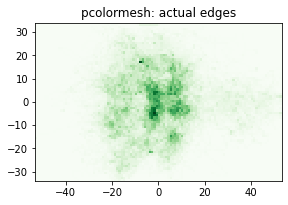

In [9]:
# Density
x_coo, y_coo = get_coordinates_individual(tracking_home_st, 'Home_1', 0, 100000)

colors = ['Greens', "Oranges", 'Reds',  'Puples', 'Blues', ]
cmap = plt.get_cmap('Greens')


# grid size precision, field 105x68
x_bins = range(-53, 54) # 1 per meter
y_bins = range(-34, 35) # 1 per meter
max_range = [[-53, 53], [-34, 34]]
#field meters
# field_dimen = (106.0,68.0)
fig = plt.figure(figsize=(15, 5))
H, xedges, yedges  = np.histogram2d(x_coo_team, y_coo_team, bins=[x_bins, y_bins], density=True)
ax = fig.add_subplot(132, title='pcolormesh: actual edges', aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
#swapaxes to fix, don't understand why
ax.pcolormesh(X, Y, np.swapaxes(H, 0, 1), cmap=cmap)


In [10]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, linewidth=3, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    #return ax.add_patch(ellipse)
    return ellipse

No handles with labels found to put in legend.


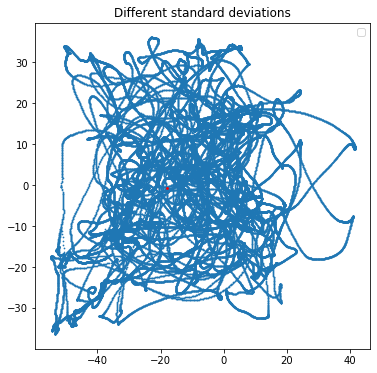

In [11]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

mu = np.mean(x_coo_player), np.mean(y_coo_player)

x_coo_player, y_coo_player = get_coordinates_individual(tracking_home, 'Home_10', 0, 100000)

x = x_coo_player
y = y_coo_player
ax_nstd.scatter(x, y, s=0.5)

confidence_ellipse(x, y, ax_nstd, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

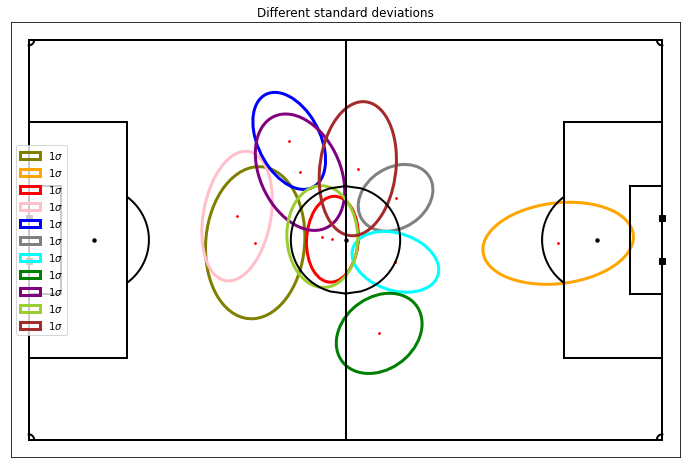

In [12]:
#def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
# edgecolor = 'firebrick'fuchsiablue

def draw_pos_ellipse(x_coordinates_player, y_coordinates_player, figax=None, color='blue'):
    if figax is None: # create new pitch 
        fig,ax = mviz.plot_pitch(field_color='white')
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    

    mu = np.mean(x_coordinates_player), np.mean(y_coordinates_player)
    #x_coo_player, y_coo_player = get_coordinates_individual(tracking_home, 'Home_10', 0, 100000)
    x = x_coordinates_player
    y = y_coordinates_player
    #ax.scatter(x, y, s=0.5)

    ax.add_patch(confidence_ellipse(x, y, ax, n_std=1,
                       label=r'$1\sigma$', edgecolor=color))
    """
    ax.add_patch(confidence_ellipse(x, y, ax, n_std=2,
                       label=r'$2\sigma$', edgecolor=color, linestyle='--'))
    ax.add_patch(confidence_ellipse(x, y, ax, n_std=3,
                       label=r'$3\sigma$', edgecolor=color, linestyle=':'))
    """
    ax.scatter(mu[0], mu[1], c='red', s=3)
    ax.set_title('Different standard deviations')
    ax.legend()
    return fig, ax

colors = ['olive', 'orange', 'red', 'pink', 'blue', 'gray', 'cyan', 'green', 
         'purple', 'yellowgreen', 'brown']

figax = None
for idx in range(11):
    fig, ax = draw_pos_ellipse(player_coos[idx][1], player_coos[idx][2], figax, colors[idx%11]) 
    figax = (fig,ax)

#fig, ax = draw_pos_ellipse(player_coos[1][1], player_coos[1][2], figax, 'blue') 

#fig, ax = draw_pos_ellipse(player_coos[2][1], player_coos[2][2], figax, 'fuchsia') 





